# Using mcmcsampler: a demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import m2c3.proposal as proposal
from m2c3.sampler import Sampler

import multiprocessing as mp
mp.set_start_method('fork') #needed for MacOS
import warnings
warnings.filterwarnings('ignore')

## Define a log-likelihood function

Here we take a simple multi dimensional Gaussian. 
We use a ```class``` to easily store all the meta data needed to evaluate the log-likelihood

In [2]:
class TestLogLik:
    """ A multi dimensional Gaussian
    """
    def __init__(self, ndim):
        """ Init number of dimensions. 
        """
        self.ndim = ndim
        self.param_dic = [f"p{i}" for i in range(ndim)]
        means = np.random.rand(ndim)
        cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
        cov = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        cov = np.dot(cov, cov)
        self.mu = means
        self.cov = cov
        
    def loglik(self, x, **kwargs):
        """ Return log-likelihood for a given point x. 
        """
        diff = x - self.mu
        return -0.5 * np.dot(diff, np.linalg.solve(self.cov, diff))
    
    def logpi(self, p, **kwargs):
        """ Return log-prior for a given point x. 
        """
        return -7.0

## Define the sampler

In [3]:
# Multi chains parameters
Nchains = 5

# Define likelihood, priors and starting point
ndim = 3
T = TestLogLik(ndim)
priors = np.array([-3,3]*T.ndim).reshape(T.ndim,2)
x0 = [np.random.randn(T.ndim) for n in range(Nchains)]
S = Sampler(Nchains, priors, T.loglik, T.logpi, T.param_dic, profiling=True, kde=True)
S.set_starting_point(x0)

## Define the proposals

In [4]:
# Define proposals
SL = proposal.Slice(T.param_dic).slice
SC = proposal.SCAM(T.param_dic).SCAM
#KDE = proposal.AdaptiveKDE(T.param_dic).kde_jump
p_dict = [{SC:50, SL:50}]*Nchains
S.set_proposals(p_dict)

## Run the sampler

In [5]:
# Run mcmc
%pdb
niter = 5000
c = S.run_mcmc(niter, printN=2000, multiproc=False)

Automatic pdb calling has been turned ON
INFO:root:iter 0
INFO:root:chain 0
INFO:root:current loglik: -68.2, best: -68.2, temp: 1.0, ratio: 1.0
INFO:root:chain 1
INFO:root:current loglik: -2593.6, best: -2593.6, temp: 1.0, ratio: 1.0
INFO:root:chain 2
INFO:root:current loglik: -677.5, best: -677.5, temp: 1.0, ratio: 1.0
INFO:root:chain 3
INFO:root:current loglik: -291.7, best: -291.7, temp: 1.0, ratio: 1.0
INFO:root:chain 4
INFO:root:current loglik: -3606.3, best: -3606.3, temp: 1.0, ratio: 1.0
INFO:root:iter 2000
INFO:root:chain 0
INFO:root:current loglik: -2.6, best: -0.0, temp: 1.0, ratio: 1.0
INFO:root:chain 1
INFO:root:current loglik: -0.8, best: -0.0, temp: 1.0, ratio: 1.0
INFO:root:chain 2
INFO:root:current loglik: -0.9, best: -0.0, temp: 1.0, ratio: 1.0
INFO:root:chain 3
INFO:root:current loglik: -7.2, best: -0.0, temp: 1.0, ratio: 1.0
INFO:root:chain 4
INFO:root:current loglik: -2.4, best: -0.0, temp: 1.0, ratio: 1.0
INFO:root:iter 4000
INFO:root:chain 0
INFO:root:current logl

## Show posterior for 1st parameter

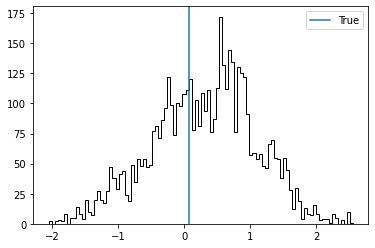

In [6]:
# Plot distribution of first parameter
C0 = np.array(S.chains[0].chn)
plt.figure()
plt.hist(C0[:,0],  bins=100, color="k", histtype="step")
plt.axvline(x=T.mu[0], label='True')
plt.legend()

## Show likelihood evolution

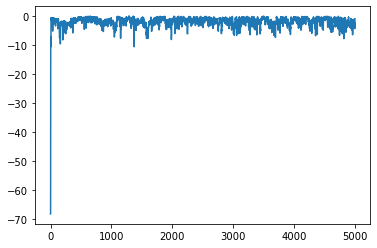

In [7]:
L = np.load("chain_0.npy")[:,-1]
plt.figure()
plt.plot(L)

## Show statistics

In [8]:
prop_names = [k.__self__.name for k,v in p_dict[0].items()]
jumps_t = np.rec.fromarrays( [np.zeros((Nchains))]*len(prop_names), names=prop_names)
ar_t = np.rec.fromarrays( [np.zeros((Nchains))]*len(prop_names), names=prop_names)
nswap = np.zeros((Nchains, 2))
for i in range(Nchains):
    s = pickle.load(open(f"stats_{i}.pkl", 'rb'))
    for n in prop_names:
        jumps_t[n][i] = s[n]['njump'] 
        ar_t[n][i] = s[n]['ar'] 

### Acceptance rate for each proposals

Text(0, 0.5, 'Number of MH steps')

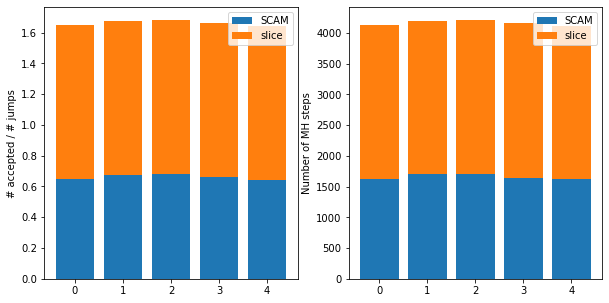

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
y_offset = np.zeros((Nchains))
for n in prop_names:
    plt.bar(np.arange(0, Nchains), height=ar_t[n]/jumps_t[n], bottom=y_offset, label=n)
    y_offset += ar_t[n]/jumps_t[n]
plt.legend()
plt.ylabel("# accepted / # jumps")

plt.subplot(122)
y_offset = np.zeros((Nchains))
for n in prop_names:
    plt.bar(np.arange(0, Nchains), height=ar_t[n], bottom=y_offset, label=n)
    y_offset += ar_t[n]
plt.legend()
plt.ylabel("Number of MH steps")